In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from Bio import BiopythonParserWarning
warnings.simplefilter('ignore', BiopythonParserWarning)

In [7]:
def get_sequence(row, pdb = True)->str:
    """

        Get sequence between r1_bond and r2_bond from structure
    
    """
    structure_path = row["structure_path"]
    if pdb:
        r1 = row["Position 1\r\n(Bond 1)"]
        r3 = row["Position 3\r\n(Bond 2)"]
    else:
        r1 = row["r1_af"]
        r3 = row["r3_af"]
    seq_start = min([r1, r3])
    seq_end = max([r1, r3])
    sequence = list(SeqIO.parse(structure_path, "pdb-atom"))[0]
    # Adjust seq start and end based on pdb seq structure start and end
    pdb_start = sequence.annotations["start"]
    return str(sequence.seq)[seq_start:seq_end]

In [8]:
load_dotenv("../.env")

AFDB_JESS_SCAN_TABLE = os.getenv("AFDB_JESS_SCAN_TABLE")
AFDB_DOMAINS= os.getenv("AFDB_DOMAINS")
ADH_TABLE = os.getenv("ADH_TABLE")
STALK_TABLE = os.getenv("STALK_TABLE")
PDB_BIOCHEM = os.getenv("PDB_BIOCHEM")
AFDB_SCAN_SEQS = os.getenv("AFDB_SCAN_SEQS")
AFDB_ISOPEP_DOMAINS = os.getenv("AFDB_ISOPEP_DOMAINS")

non_isopep = ["TED_2", "TQ", "Gram_pos_anchor", "Cu-oxidase_2", "Helicase_C_2", "Gram_pos_anchor"]
isopep = ['Collagen_bind', 'GramPos_pilinBB', 'AgI_II_C2', 'Antigen_C',
       'Sgo0707_N2', 'DUF11', 'DUF7507', 'DUF7619', 'GBS104-like_Ig',
       'DUF7617', 'CARDB', 'SpaA', 'Cna_B', 'FctA', 'DUF5979',
       'GramPos_pilinD1', 'DUF7601', 'SpaA_4', 'SpaA_2', 'SpaA_3',
       'GramPos_pilinD3', 'SdrD_B']

adh_df = pd.read_csv(ADH_TABLE)
stalk_df = pd.read_csv(STALK_TABLE)

str_df = pd.read_csv(AFDB_JESS_SCAN_TABLE)
str_df["phylum"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[1].replace(".", "") if len(str(x).split(";")) >= 2 else None)

strd_df = pd.read_csv(AFDB_DOMAINS)

seq_df = pd.read_csv(AFDB_SCAN_SEQS)

pdb_df = pd.read_csv(PDB_BIOCHEM)
pdb_df["isopep_sequence"] = pdb_df.apply(get_sequence, pdb=True, axis=1)

afdb_isopep_domains = pd.read_csv(AFDB_ISOPEP_DOMAINS)

In [9]:
# Find sortase motifs

S = re.compile('LP.T[G|A|N|D]')
S2 = re.compile('NP.TG')
S3 = re.compile('LP.GA')
S4 = re.compile('LA.TG')
S5 = re.compile('NPQTN')
S6 = re.compile('IP.TG')

def find_sortase(seq:str):
    """
    
        Find sortase motifs within 50 amino acids from C-ter
    
    """
    sortase = False
    seq = seq[-50:]
    if S.findall(seq):
        sortase = True
    elif S2.findall(seq):
        sortase = True
    elif S3.findall(seq):
        sortase = True
    elif S4.findall(seq):
        sortase = True
    elif S5.findall(seq):
        sortase = True
    elif S6.findall(seq):
        sortase = True
    
    return sortase

ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"]=="Bacteria")&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
sub_df = seq_df[(seq_df["uniprot_acc"].isin(ib_proteins))].copy()
sub_df["Sortase motif"] = sub_df["sequence"].apply(find_sortase)

# Add to domains database
strd_df = pd.concat([strd_df, sub_df[(sub_df["Sortase motif"])][["uniprot_acc"]]\
        .assign(pfamA_id="Sortase motif")\
        .assign(pfamA_acc="PFXXXXX")[["uniprot_acc", "pfamA_acc", "pfamA_id"]]])

## Table 1

In [5]:
import sys
sys.path.append("../bin")
from pfamenv import PFAM_HOST,PFAM_PASSWORD,PFAM_PORT,PFAM_USER,PFAM_VERSION
from mysql import connector
import numpy as np

def is_domain(row):
    """

        Assign if at least 2/3 residues are in domain
    
    """
    residues = [row["r1_bond"], row["r_cat"], row["r2_bond"]]
    status = False
    c = 0
    for res in residues:
        if res >= row["seq_start"] and res <= row["seq_end"]:
            c += 1
            #status = True
            #break
    if c >= 2:
        status = True
    return status

In [7]:
# Get pfam info associated with each PDB
columns = ["pdb_id", "pfamA_acc", "pfamA_id", "chain", "pdb_res_start", "pdb_res_end", "seq_start", "seq_end", "clan_acc", "clan_id"]

proteins = pdb_df[(pdb_df["Is bonded"])&(~pdb_df["Interchain"])&(pdb_df["Isopeptide type"]!="Mutant")]["PDB code"].unique()

cnx = connector.connect(user=PFAM_USER,
                        password=PFAM_PASSWORD,
                        port=PFAM_PORT,
                        host=PFAM_HOST)
cursor = cnx.cursor()

proteins_ = ", ".join([f"'{protein}'" for protein in proteins])

# Get domains
cursor.execute(f"SELECT pdb_id,pfamA.pfamA_acc,pfamA.pfamA_id,chain,pdb_res_start,pdb_res_end,seq_start,seq_end,\
                    clan_membership.clan_acc,clan.clan_id \
                 FROM {PFAM_VERSION}.pdb_pfamA_reg, {PFAM_VERSION}.pfamA, \
                     {PFAM_VERSION}.clan_membership, {PFAM_VERSION}.clan \
                 WHERE pdb_id IN ({proteins_}) \
                 AND pfamA.pfamA_acc = clan_membership.pfamA_acc \
                 AND clan.clan_acc=clan_membership.clan_acc \
                 AND pfamA.pfamA_acc = pdb_pfamA_reg.pfamA_acc")
output = cursor.fetchall()
d_df = pd.DataFrame(output, columns = columns)
d_df["pdb_id"] = d_df["pdb_id"].apply(lambda x: x.lower())
data_df = pd.merge(pdb_df, d_df.rename(columns={"pdb_id":"PDB code", "chain":"Chain"}), how="left")\
        .rename(columns={"Position 1\r\n(Bond 1)":"r1_bond", "Position 2\r\n(catalytic)":"r_cat", "Position 3\r\n(Bond 2)":"r2_bond"})

# Check which domains map to isopep bonds
data_df["is_domain"] = data_df.apply(lambda x: is_domain(x), axis=1)
data_df = data_df.sort_values("is_domain", ascending=False) \
        .drop_duplicates(["PDB code", "r1_bond", "r_cat", "r2_bond"], keep="first")
data_df.loc[data_df["is_domain"]==False, "pfamA_acc"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "pfamA_id"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_start"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_end"] = np.NaN
data_df["seq_start"] = data_df["seq_start"].fillna(0).astype(int)
data_df["seq_end"] = data_df["seq_end"].fillna(0).astype(int)
data_df["residues"] = data_df.apply(lambda x: ", ".join([str(_) for _ in [x["r1_bond"], x["r_cat"], x["r2_bond"]]]), axis=1)
data_df["PDB code"] = data_df["PDB code"].apply(lambda x: x.upper())

In [13]:
data_df[["pfamA_id", "pfamA_acc", "clan_id", "PDB code", "Chain", "seq_start", "seq_end", "residues"]]\
.drop_duplicates("pfamA_id").set_index("pfamA_id").sort_values("clan_id")

,pfamA_acc,clan_id,PDB code,Chain,seq_start,seq_end,residues
pfamA_id,,,,,,,
AgI_II_C2,PF17998,Adhesin,5DZ9,A,554,723,"556, 606, 703"
Sgo0707_N2,PF20623,Adhesin,4HSS,A,178,324,"187, 224, 299"
GramPos_pilinBB,PF16569,Adhesin,2X9Z,A,216,328,"193, 241, 318"
Collagen_bind,PF05737,Adhesin,7LGR,A,173,306,"177, 210, 291"
Antigen_C,PF16364,Adhesin,3OPU,A,1334,1492,"1334, 1383, 1469"
GBS104-like_Ig,PF21426,E-set,3TXA,A,587,717,"188, 597, 692"
DUF5979,PF19407,Transthyretin,4BUG,A,606,718,"610, 680, 715"
SpaA,PF17802,Transthyretin,2XID,A,291,377,"297, 347, 595"
GramPos_pilinD3,PF16570,Transthyretin,2X9Z,A,388,448,"349, 405, 428"


## Table S2

In [6]:
false_positives = ["Cu-oxidase_2", "Helicase_C_2", "TED_2", "TQ", "Gram_pos_anchor"]
table_df = str_df[(str_df["probability"]>0.65)&(~str_df["taxonomy"].isna())&(~str_df["pfamA_id"].isin(false_positives))] \
        .value_counts(["pfamA_id", "pfamA_acc", "clan_id", "clan_acc", "bond_type"]) \
        .reset_index() \
        .query('count>20') \
        .rename(columns={"count":"isopeptor_count"}) \
    .fillna(0) \
    .sort_values(["clan_id", "isopeptor_count"], ascending=[True, False]).reset_index(drop=True)
isopep_domains = table_df["pfamA_id"].unique()

table_df = table_df.merge(afdb_isopep_domains[afdb_isopep_domains["pfamA_id"].isin(isopep_domains)]\
    .value_counts(["pfamA_id"]) \
    .reset_index() \
    .rename(columns={'count': "total_count"}), on="pfamA_id")
table_df["pfamA_id"] = table_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
table_df["Pfam ID (accession code)"] = table_df.apply(lambda x: f'{x["pfamA_id"]} ({x["pfamA_acc"]})', axis=1)
table_df["Pfam Clan ID (accession code)-isopeptide bond class type"] = table_df.apply(lambda x: f'{x["clan_id"]} ({x["clan_acc"]}) - Cna', axis=1)
table_df = table_df.rename(columns={"isopeptor_count":"Predicted to contain an isopeptide bond",
                                    "total_count": "Total number of domains present in the AFDB"})
table_df = table_df[["Pfam ID (accession code)", 
          "Pfam Clan ID (accession code)-isopeptide bond class type",
          "Total number of domains present in the AFDB",
          "Predicted to contain an isopeptide bond"]]
          
table_df["Total number of domains present in the AFDB"] = \
    table_df["Total number of domains present in the AFDB"].apply(lambda x: "{:,}".format(x)) 
table_df["Predicted to contain an isopeptide bond"] = \
    table_df["Predicted to contain an isopeptide bond"].apply(lambda x: "{:,}".format(x)) 
table_df.to_csv("../output/table_s2.csv", index=False)
table_df

,Pfam ID (accession code),Pfam Clan ID (accession code)-isopeptide bond class type,Total number of domains present in the AFDB,Predicted to contain an isopeptide bond
0,Collagen_bind (PF05737),Adhesin (CL0204) - Cna,"2,589","2,307"
1,GramPos_pilinBB (PF16569),Adhesin (CL0204) - Cna,"2,226","2,044"
2,AgI_II_C2 (PF17998),Adhesin (CL0204) - Cna,876,684
3,Antigen_C (PF16364),Adhesin (CL0204) - Cna,316,246
4,Sgo0707_N2 (PF20623),Adhesin (CL0204) - Cna,274,171
5,DUF7926 (PF25548),Adhesin (CL0204) - Cna,181,148
6,DUF7929 (PF25551),Adhesin (CL0204) - Cna,162,123
7,DUF7925 (PF25546),Adhesin (CL0204) - Cna,154,109
8,CLIPPER (PF01345),E-set (CL0159) - Cna,"25,913","11,756"
9,CLIPPER_2 (PF24346),E-set (CL0159) - Cna,"5,318","3,146"


In [15]:
# Note that some domains have multiple low prob. hits
pd.merge(afdb_isopep_domains[afdb_isopep_domains["pfamA_acc"]=="PF24346"],
    str_df[str_df["pfamA_acc"]=="PF24346"].sort_values("probability", ascending=False) \
        .drop_duplicates(["uniprot_acc","seq_start", "seq_end"], keep="first") \
        [list(afdb_isopep_domains.columns) + ["probability"]], how="outer").query('probability.isna()') \
        .sort_values(["uniprot_acc", "seq_start"]).iloc[0:20]

,uniprot_acc,pfamA_acc,pfamA_id,seq_start,seq_end,probability
0,A0A022L2G3,PF24346,DUF7507,1,41,NaN
1,A0A022L2G3,PF24346,DUF7507,52,158,NaN
2,A0A022L2G3,PF24346,DUF7507,169,275,NaN
3,A0A022L2G3,PF24346,DUF7507,286,392,NaN
4,A0A022L2G3,PF24346,DUF7507,403,504,NaN
5,A0A022L2G3,PF24346,DUF7507,499,564,NaN
6,A0A022L2G3,PF24346,DUF7507,575,645,NaN
7,A0A022LAR6,PF24346,DUF7507,284,391,NaN
8,A0A022LC91,PF24346,DUF7507,391,496,NaN
12,A0A022LDT9,PF24346,DUF7507,1,38,NaN


In [9]:
str_df[str_df["uniprot_acc"]=="A0A086ZW58"][list(afdb_isopep_domains.columns)+["probability", "r1_bond", "r_cat", "r2_bond"]]

,uniprot_acc,pfamA_acc,pfamA_id,seq_start,seq_end,probability,r1_bond,r_cat,r2_bond
151156,A0A086ZW58,PF17998,AgI_II_C2,427.0,603.0,0.814,429,476,583
151276,A0A086ZW58,PF17998,AgI_II_C2,271.0,422.0,0.883,272,321,402
151316,A0A086ZW58,PF16364,Antigen_C,607.0,776.0,0.893,610,657,755
419663,A0A086ZW58,NaN,NaN,NaN,NaN,0.613,66,123,244


In [ ]:
# Note that some domains have multiple low prob. hits
pd.merge(afdb_isopep_domains[afdb_isopep_domains["pfamA_acc"]=="PF24346"],
    str_df[str_df["pfamA_id"]=="PF24346"].sort_values("probability", ascending=False) \
        .drop_duplicates(["uniprot_acc","seq_start", "seq_end"], keep="first") \
        [list(afdb_isopep_domains.columns) + ["probability"]], how="outer").sort_values(["uniprot_acc", "seq_start"]).iloc[20:40]

In [11]:
str_df[str_df["pfamA_id"]=="SdrD_B"].value_counts("r_cat_name")

r_cat_name
GLU    551
ASP      5
Name: count, dtype: int64

## Table S1

In [10]:
cond1 = (pdb_df["Is bonded"])
cond2 = (pdb_df["Isopeptide type"]!="Mutant")
cond3 = (~pdb_df["Unusual geometry/chemistry"])
cond4 = (pdb_df["Resolution"]<=2.5)
cond5 = (~pdb_df["Bad rotamer"])
table_df = pdb_df[cond1&cond2&cond3&cond4&cond5].drop_duplicates("isopep_sequence").copy()



In [11]:
table_df[table_df["water_distance_OD"]<5][["PDB code", "Position 1\r\n(Bond 1)", "water_distance_OD", "water_resid_OD"]]

,PDB code,Position 1\r\n(Bond 1),water_distance_OD,water_resid_OD
7,2x5p,31,2.319172,2101.0
16,2okm,42,3.222581,267.0
17,3b2m,179,4.411066,416.0
19,3gle,179,4.939684,398.0
21,3hr6,363,2.643870,733.0
22,3hr6,199,3.539691,17.0
23,3htl,363,4.311486,991.0
24,3htl,199,3.473336,19.0
27,2ww8,191,2.579303,2692.0
28,2ww8,742,3.360727,2776.0


In [12]:
table_df.loc[table_df["water_distance_NZ"]<=5, "water_distance_NZ"] = True
table_df.loc[table_df["water_distance_NZ"]!=True, "water_distance_NZ"] = False

table_df.loc[table_df["water_distance_OD"]<=5, "water_distance_OD"] = True
table_df.loc[table_df["water_distance_OD"]!=True, "water_distance_OD"] = False

table_df.loc[table_df["o_atom_distance"]<=5, "o_atom_distance"] = True
table_df.loc[table_df["o_atom_distance"]!=True, "o_atom_distance"] = False

pd.concat([table_df.groupby("Isopeptide type").value_counts(["water_distance_NZ"], normalize=True).round(2).reset_index(),
     table_df.groupby("Isopeptide type").value_counts(["water_distance_OD"], normalize=True).round(2).reset_index(),
     table_df.groupby("Isopeptide type").value_counts(["o_atom_distance"], normalize=True).round(2).reset_index()
     ])


/tmp/ipykernel_3355243/3411342314.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_df.loc[table_df["water_distance_NZ"]<=5, "water_distance_NZ"] = True
/tmp/ipykernel_3355243/3411342314.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_df.loc[table_df["water_distance_OD"]<=5, "water_distance_OD"] = True
/tmp/ipykernel_3355243/3411342314.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_df.loc[table_df["o_atom_distance"]<=5, "o_atom_distance"] = True


,Isopeptide type,water_distance_NZ,proportion,water_distance_OD,o_atom_distance
0,CnaA-like,False,0.54,NaN,NaN
1,CnaA-like,True,0.46,NaN,NaN
2,CnaB-like,False,0.69,NaN,NaN
3,CnaB-like,True,0.31,NaN,NaN
0,CnaA-like,NaN,0.69,True,NaN
1,CnaA-like,NaN,0.31,False,NaN
2,CnaB-like,NaN,0.55,True,NaN
3,CnaB-like,NaN,0.45,False,NaN
0,CnaA-like,NaN,0.89,NaN,True
1,CnaA-like,NaN,0.11,NaN,False


In [17]:
table_df.groupby("Isopeptide type")["water_distance_OD"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,Isopeptide type,water_distance_OD,percentage
0,CnaA-like,True,69.0
1,CnaA-like,False,31.0
2,CnaB-like,True,55.0
3,CnaB-like,False,45.0


In [18]:
table_df.groupby("Isopeptide type")["o_atom_distance"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,Isopeptide type,o_atom_distance,percentage
0,CnaA-like,True,89.0
1,CnaA-like,False,11.0
2,CnaB-like,True,82.0
3,CnaB-like,False,18.0


In [9]:
table_df.value_counts("Isopeptide type")

Isopeptide type
CnaB-like    65
CnaA-like    49
Name: count, dtype: int64

In [12]:
round(56/65, 2)

0.86

In [30]:
table_df.value_counts(["water_distance_OD", "aro_cap"])

water_distance_OD  aro_cap
False              True       32
True               False      32
                   True       32
False              False      18
Name: count, dtype: int64

In [27]:
round(32/(32+32+32+18),2)

0.28

In [31]:
table_df[~table_df["aro_cap"]].value_counts(["water_distance_OD"], normalize=True)

water_distance_OD
True                 0.64
False                0.36
Name: proportion, dtype: float64

## Table S3

In [138]:
str_df["genus"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[-1].replace(".", "").strip() if len(str(x).split(";")) >= 5 else None)
archaea = str_df[(str_df["probability"]>0.65)&(str_df["kingdom"]=="Archaea")]\
    .drop_duplicates("uniprot_acc")\
    .value_counts(["genus", "kingdom"])\
    .reset_index()\
    .query("count>10")["genus"]\
    .to_list()
bacteria = str_df[(str_df["probability"]>0.65)&(str_df["kingdom"]=="Bacteria")]\
    .drop_duplicates("uniprot_acc")\
    .value_counts(["genus", "kingdom"])\
    .reset_index()\
    .query("count>100")["genus"]\
    .to_list()

In [142]:
# Counts of domains co-localising with IB domains per organism genus

ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]
# Add genus information
count_df = pd.merge(count_df, str_df[["uniprot_acc", "kingdom", "genus"]])
# Group genera with low counts into other archaea/bacteria
count_df.loc[(count_df["kingdom"]=="Archaea")&(~count_df["genus"].isin(archaea)), "genus"] = "Other archaea"
count_df.loc[(count_df["kingdom"]=="Bacteria")&(~count_df["genus"].isin(bacteria)), "genus"] = "Other bacteria"

# Count values
plot_df = count_df.value_counts(["kingdom", "genus", "pfamA_acc", "pfamA_id"]).reset_index()

adhesin = adh_df["Pfam ID"].unique()
stalk = stalk_df["Pfam ID"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM"]

plot_df["Domain function"] = "Unknown"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_acc"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_acc"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"


# Consider only domains with more than X counts
domains_to_consider = plot_df[plot_df["count"]>50]["pfamA_id"].unique()

# Apply log counts
#plot_df["count"] = plot_df["count"].apply(np.log10)
plot_df = plot_df[plot_df["pfamA_id"].isin(domains_to_consider)]\
    .sort_values("Domain function")\
    .pivot(index=["kingdom", "genus"], 
            columns=["Domain function", "pfamA_id"], values="count").fillna(0).astype(int)
plot_df = plot_df.apply(np.log10)

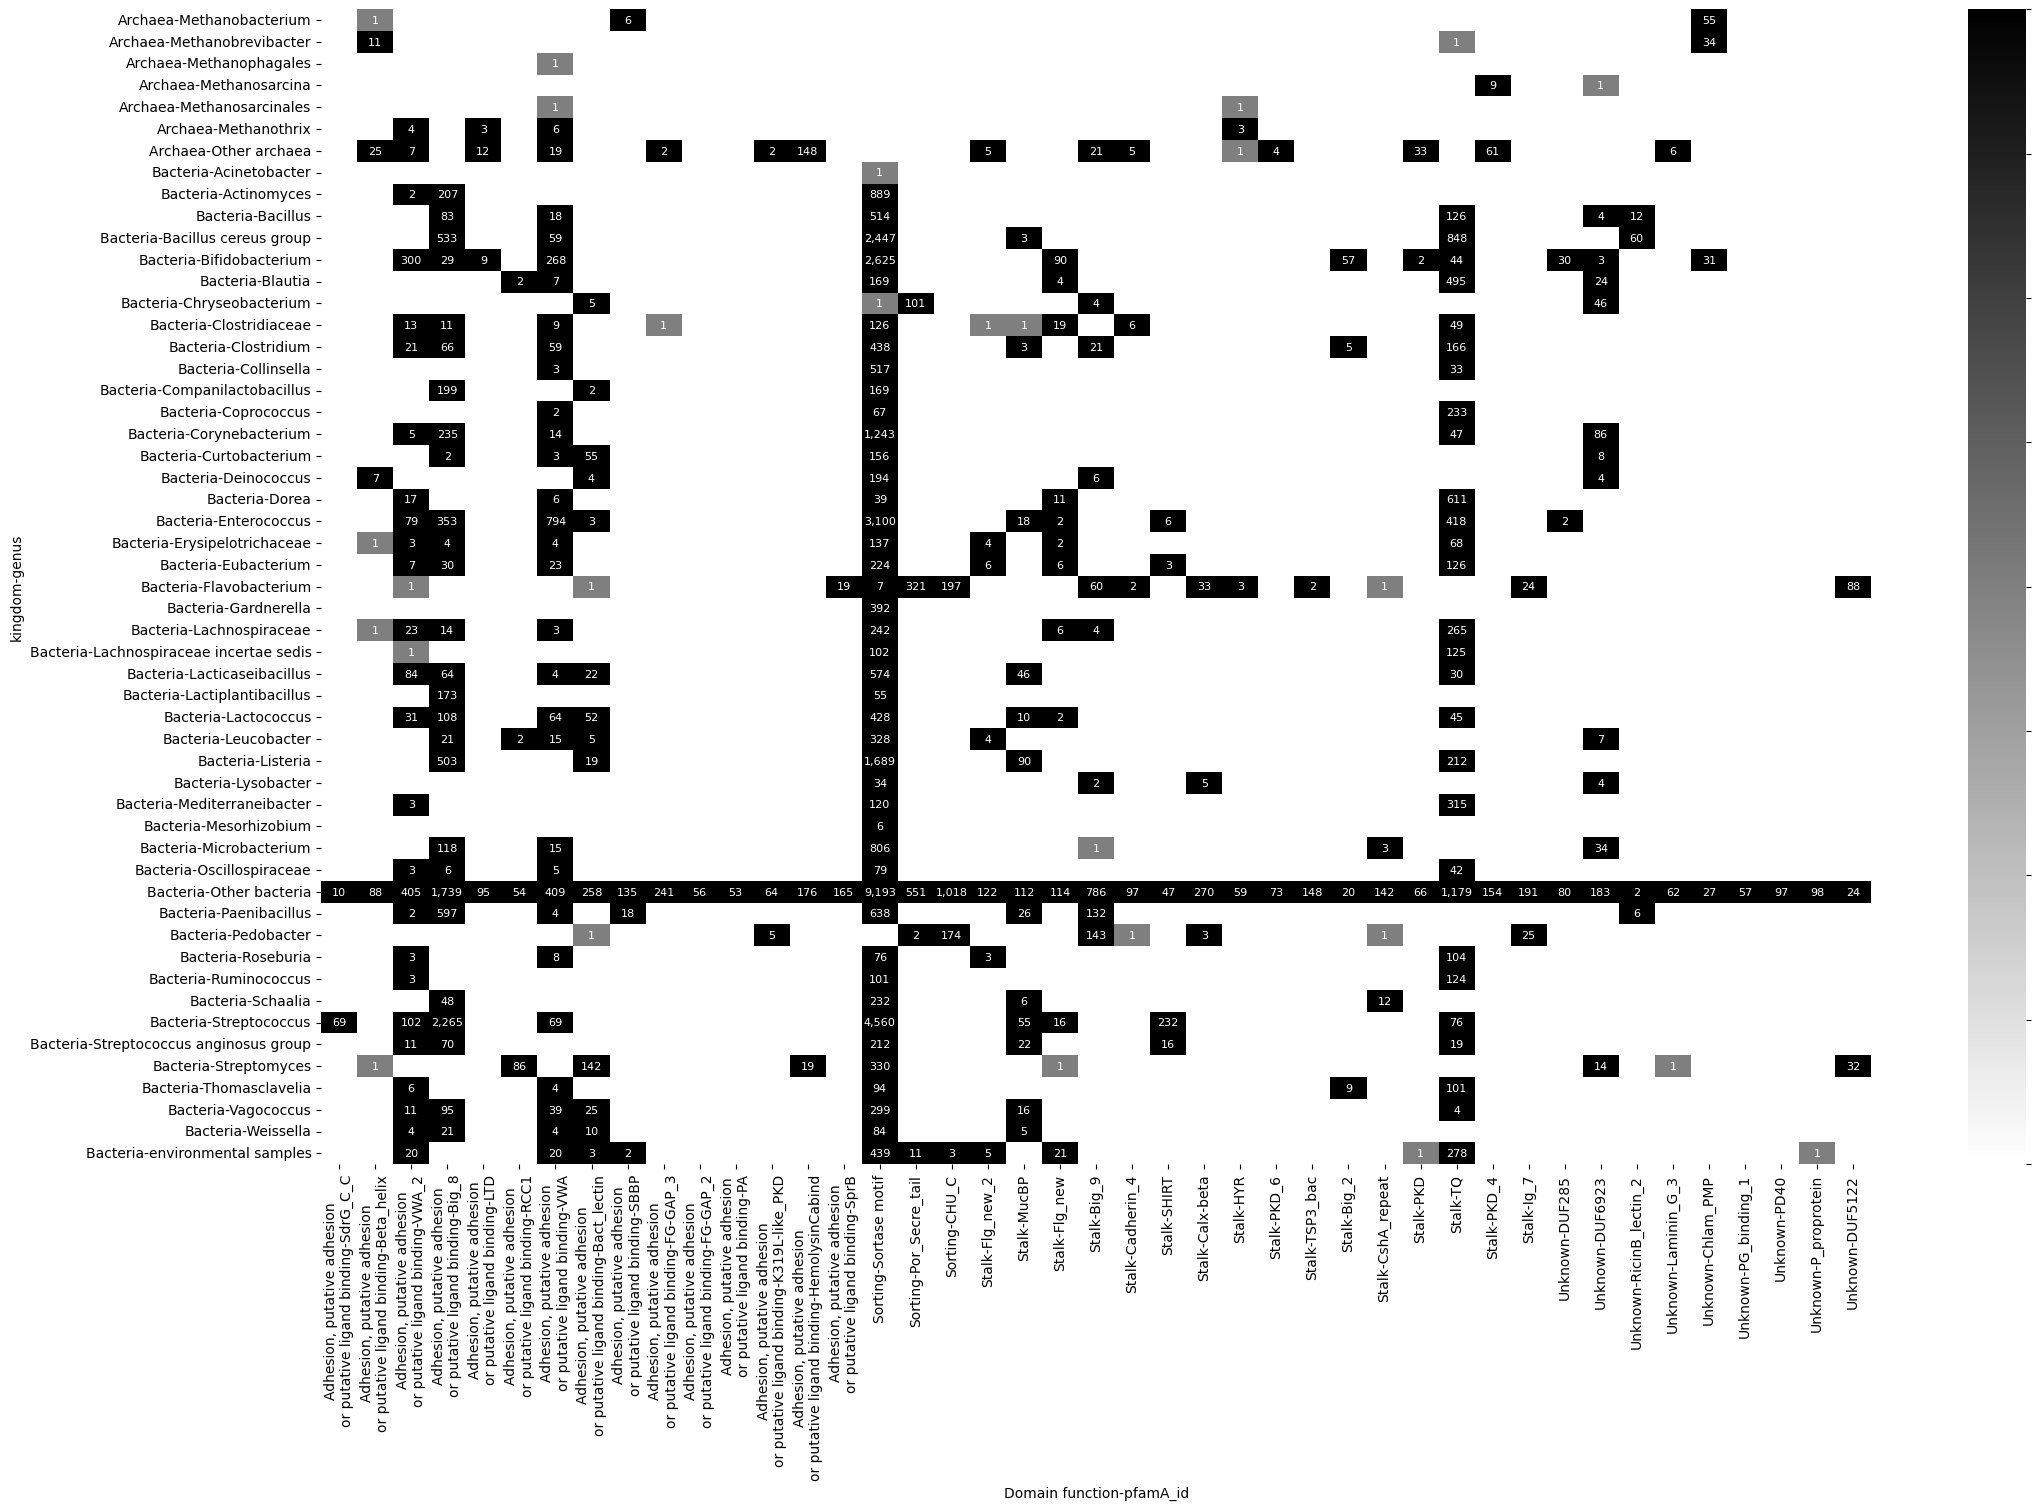

In [143]:
fig, ax = plt.subplots(figsize=[25, 15])
g=sns.heatmap(plot_df, cmap="binary",
            annot=np.vectorize(lambda x: f"{10**x:,.0f}")(plot_df),
            fmt="s",
            annot_kws={"fontsize": 8},
            cbar_kws={"format": "%.0e"})

cbar = g.collections[0].colorbar
cbar_ticks = cbar.get_ticks()
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([])

plt.savefig("../tmp/demo_heatmap.png")

In [155]:
pdb_df[(pdb_df["Isopeptide type"]!="Mutant")&(~pdb_df["Unusual geometry/chemistry"])].drop_duplicates("isopep_sequence").value_counts(["Residue 2", "aro_cap"])

Residue 2  aro_cap
E          False      59
D          True       52
E          True       33
D          False      10
Name: count, dtype: int64

In [153]:
pdb_df[(pdb_df["Isopeptide type"]!="Mutant")&(~pdb_df["Unusual geometry/chemistry"])].drop_duplicates("isopep_sequence").value_counts(["Residue 3", "aro_cap"])

Residue 3  aro_cap
N          True       85
           False      51
D          False      18
Name: count, dtype: int64

,PDB code,Chain,UniProt Id,Species,Name,Position 1\r\n(Bond 1),Residue 1,Position 2\r\n(catalytic),Residue 2,Position 3\r\n(Bond 2),...,o_atom_ref,o_atom_distance,rASA,bond_length,pseudo_omega,pseudo_psi,pseudo_phi,lys_x3,lys_x4,isopep_sequence
0,1d2p,A,Q53654,Staphylococcus aureus,Cna,820,K,881,E,904,...,THR_890_OG1,3.906153,"[0.010724496841430665, 0.15328148099565014, 0.0]",2.751728,-165.772776,118.419306,136.114919,64.050270,136.114919,INGTTITNKYTPGETSATVTKNWDDNNNQDGKRPTEIKVELYQDGK...
1,1d2p,A,Q53654,Staphylococcus aureus,Cna,543,K,603,E,620,...,NaN,NaN,"[0.03251750047613935, 0.026757974292814117, 0.0]",2.978798,-94.995692,129.558853,-128.849497,-55.980668,-128.849497,ETTSSIGEKVWDDKDNQDGKRPEKVSVNLLANGEKVKTLDVTSETN...
2,1d2p,A,Q53654,Staphylococcus aureus,Cna,633,K,694,E,717,...,THR_716_O,3.760117,"[0.015599267075701457, 0.11646403280115619, 0.0]",2.777919,-68.352203,128.687430,-133.030160,-80.122900,-133.030160,INGTTITNKYTPGETSATVTKNWDDNNNQDGKRPTEIKVELYQDGK...
3,1d2p,A,Q53654,Staphylococcus aureus,Cna,730,K,790,E,807,...,THR_798_OG1,2.806025,"[0.027298715637951363, 0.018408047937855276, 0.0]",3.127482,161.262324,103.802947,-140.307112,-69.580114,-140.307112,MGNLITTNKYTPETTSSIGEKVWDDKDNQDGKRPEKVSVNLLANGE...
4,1d2o,A,Q53654,Staphylococcus aureus,Cna,543,K,603,E,620,...,THR_611_OG1,2.919426,"[0.03412339512894793, 0.017151825821276792, 0.0]",3.463489,76.154786,97.942795,158.521177,46.218125,158.521177,ETTSSIGEKVWDDKDNQDGKRPEKVSVNLLANGEKVKTLDVTSETN...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,6m48,A,NaN,Lacticaseibacillus rhamnosus GG,SpaC,741,K,791,E,849,...,NaN,NaN,"[0.003770941205141021, 0.052372771747333485, 0...",1.568640,-82.984886,130.109189,-135.810307,-74.301578,-135.810307,QILTLTKYDEPKPSMTLRVIKQDNQSQYLAGAAFTLQPSAGEAETI...
190,7bvx,A,NaN,Lacticaseibacillus rhamnosus,SpaC,604,K,658,E,729,...,GLN_666_O,3.932886,"[0.20810649976497744, 0.04401354292004379, 0.0...",1.445998,147.246489,65.811612,-149.375349,169.686679,-149.375349,QYGFQFQKKTTDGTDLSADQLKAMQFNLTQYSDNSFQQASKTNAIT...
191,7bvx,A,NaN,Lacticaseibacillus rhamnosus,SpaC,741,K,791,E,849,...,NaN,NaN,"[0.04711087186162065, 0.1461060037932445, 0.10...",1.274715,102.322811,71.292470,120.485794,-168.957474,120.485794,QILTLTKYDEPKPSMTLRVIKQDNQSQYLAGAAFTLQPSAGEAETI...
192,6m7c,A,NaN,Lacticaseibacillus rhamnosus,SpaC,604,K,658,E,729,...,GLN_666_O,3.904830,"[0.25394656178427905, 0.0481418059351518, 0.03...",1.324724,124.243887,70.469773,172.599468,-178.993577,172.599468,QQYGFQFQKKTTDGTDLSADQLKAMQFNLTQYSDNSFQQASKTNAI...
